## Introduction
This is a 5 minutes demo for Density-Softmax, a fast, reliable, and scalable framework for Deep Learning under distributional shifts. In this demo, we will show that our Density-Softmax has the same distance aware performance as SNGP, while outperforming their computational efficiency (lower weight and lower inference speed) at test-ime in the two-moon dataset. More details about this setting can be founded at https://www.tensorflow.org/tutorials/understanding/sngp.


## Setup

In [1]:
!pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 22.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 44.0 MB/s eta 0:00:00
ERROR: pip's legacy dependency resolve

In [2]:
# refresh pkg_resources so it takes the changes into account.
import time
import pkg_resources
import importlib
importlib.reload(pkg_resources)

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

import numpy as np
import tensorflow as tf

import official.nlp.modeling.layers as nlp_layers

plt.rcParams['figure.dpi'] = 140

DEFAULT_X_RANGE = (-3, 3)
DEFAULT_Y_RANGE = (-2, 2)
DEFAULT_CMAP = colors.ListedColormap(["#377eb8", "#ff7f00"])
DEFAULT_NORM = colors.Normalize(vmin=0, vmax=1,)
DEFAULT_N_GRID = 100

## The two moon dataset



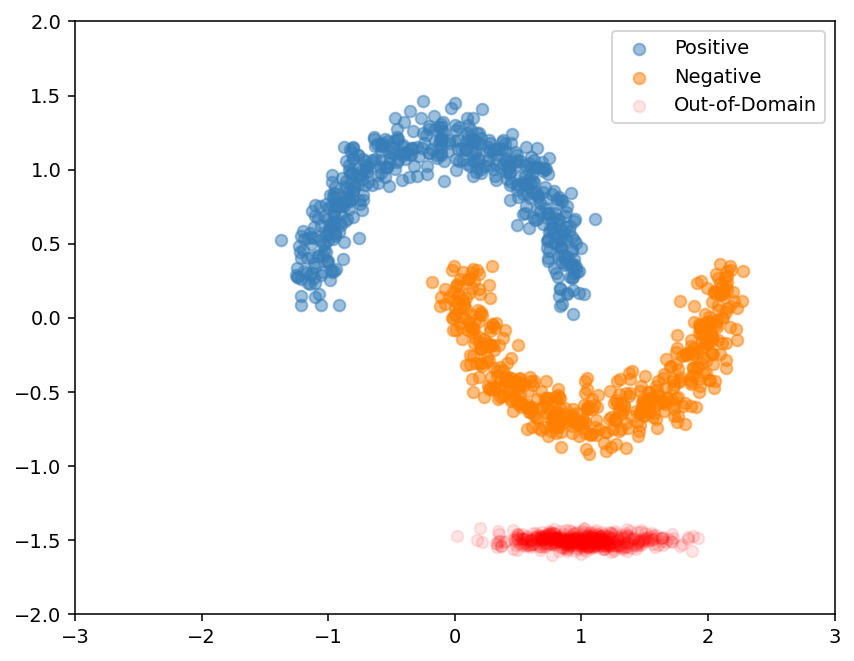

In [3]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1)

def make_ood_data(sample_size=500, means=(1, -1.5), vars=(0.1, 0.001)):
  return np.random.multivariate_normal(
      means, cov=np.diag(vars), size=sample_size)

# Load the train, test and OOD datasets.
train_examples, train_labels = make_training_data(
    sample_size=500)
test_examples = make_testing_data()
ood_examples = make_ood_data(sample_size=500)

# Visualize
pos_examples = train_examples[train_labels == 0]
neg_examples = train_examples[train_labels == 1]

plt.figure(figsize=(7, 5.5))

plt.scatter(pos_examples[:, 0], pos_examples[:, 1], c="#377eb8", alpha=0.5)
plt.scatter(neg_examples[:, 0], neg_examples[:, 1], c="#ff7f00", alpha=0.5)
plt.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

plt.legend(["Positive", "Negative", "Out-of-Domain"])

plt.ylim(DEFAULT_Y_RANGE)
plt.xlim(DEFAULT_X_RANGE)

plt.show()

## The deterministic model


In [4]:
#@title
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def encode(self, inputs):
      # Projects the 2d input data to high dimension.
      hidden = self.input_layer(inputs)

      # Computes the ResNet hidden representations.
      for i in range(self.num_layers):
        resid = self.dense_layers[i](hidden)
        resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
        hidden += resid

      return hidden

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [5]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build((None, 2))
resnet_model.summary()

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

fit_config = dict(batch_size=128, epochs=100)
resnet_model.compile(**train_config)

start_time = time.time()
resnet_model.fit(train_examples, train_labels, **fit_config)
erm_training_time = (time.time() - start_time) * 1e6 / 128

Model: "deep_res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  384       
                                                                 
 dense_1 (Dense)             multiple                  16512     
                                                                 
 dense_2 (Dense)             multiple                  16512     
                                                                 
 dense_3 (Dense)             multiple                  16512     
                                                                 
 dense_4 (Dense)             multiple                  16512     
                                                                 
 dense_5 (Dense)             multiple                  16512     
                                                                 
 dense_6 (Dense)             multiple                 

In [6]:
#@title
def plot_uncertainty_surface(test_uncertainty, ax, cmap=None):
  """Visualizes the 2D uncertainty surface.

  For simplicity, assume these objects already exist in the memory:

    test_examples: Array of test examples, shape (num_test, 2).
    train_labels: Array of train labels, shape (num_train, ).
    train_examples: Array of train examples, shape (num_train, 2).

  Arguments:
    test_uncertainty: Array of uncertainty scores, shape (num_test,).
    ax: A matplotlib Axes object that specifies a matplotlib figure.
    cmap: A matplotlib colormap object specifying the palette of the
      predictive surface.

  Returns:
    pcm: A matplotlib PathCollection object that contains the palette
      information of the uncertainty plot.
  """
  # Normalize uncertainty for better visualization.
  test_uncertainty = test_uncertainty / np.max(test_uncertainty)

  # Set view limits.
  ax.set_ylim(DEFAULT_Y_RANGE)
  ax.set_xlim(DEFAULT_X_RANGE)

  # Plot normalized uncertainty surface.
  pcm = ax.imshow(
      np.reshape(test_uncertainty, [DEFAULT_N_GRID, DEFAULT_N_GRID]),
      cmap=cmap,
      origin="lower",
      extent=DEFAULT_X_RANGE + DEFAULT_Y_RANGE,
      vmin=DEFAULT_NORM.vmin,
      vmax=DEFAULT_NORM.vmax,
      interpolation='bicubic',
      aspect='auto')

  # Plot training data.
  ax.scatter(train_examples[:, 0], train_examples[:, 1],
             c=train_labels, cmap=DEFAULT_CMAP, alpha=0.5)
  ax.scatter(ood_examples[:, 0], ood_examples[:, 1], c="red", alpha=0.1)

  return pcm

def plot_predictions(pred_probs, model_name=""):
  """Plot normalized class probabilities and predictive uncertainties."""
  # Compute predictive uncertainty.
  uncertainty = pred_probs * (1. - pred_probs)

  # Initialize the plot axes.
  fig, axs = plt.subplots(1, 2, figsize=(14, 5))

  # Plots the class probability.
  pcm_0 = plot_uncertainty_surface(pred_probs, ax=axs[0])
  # Plots the predictive uncertainty.
  pcm_1 = plot_uncertainty_surface(uncertainty, ax=axs[1])

  # Adds color bars and titles.
  fig.colorbar(pcm_0, ax=axs[0])
  fig.colorbar(pcm_1, ax=axs[1])

  axs[0].set_title(f"Class Probability, {model_name}")
  axs[1].set_title(f"(Normalized) Predictive Uncertainty, {model_name}")

  plt.show()

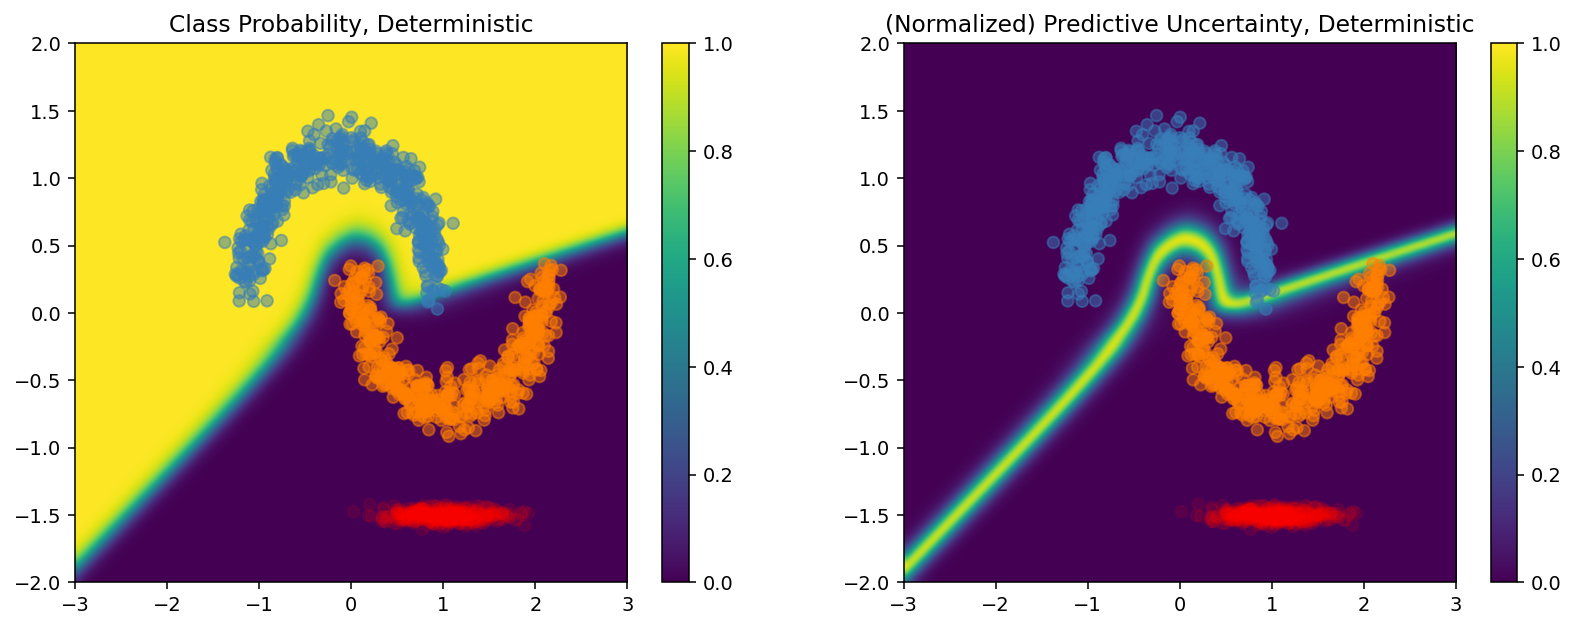

In [7]:
start_time = time.time()
resnet_logits = resnet_model(test_examples)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.
erm_infer_time = (time.time() - start_time) * 1e6

plot_predictions(resnet_probs, model_name="Deterministic")

## The SNGP model

In [8]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [9]:
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)
sngp_model.compile(**train_config)
start_time = time.time()
sngp_model.fit(train_examples, train_labels, verbose=0, **fit_config)
sngp_training_time = (time.time() - start_time) * 1e6 / 128

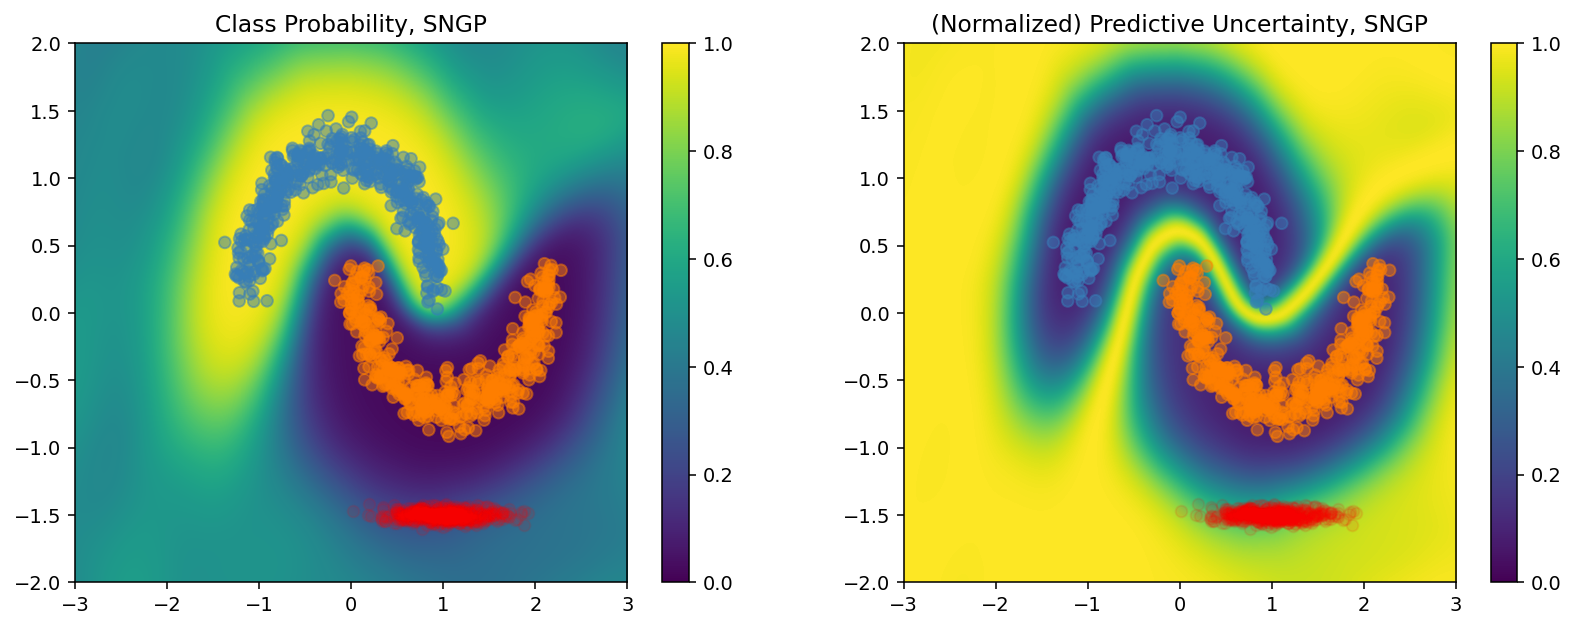

In [10]:
start_time = time.time()
sngp_logits, sngp_covmat = sngp_model(test_examples, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)
sngp_infer_time = (time.time() - start_time) * 1e6

plot_predictions(sngp_probs, model_name="SNGP")

## Our Density-Softmax

$$p(y=i \mid x_t) = \frac{e^{p(x_t;\alpha) \cdot x_t^T \theta_{g_i}}}{\sum_{j=1}^K e^{p(x_t;\alpha) \cdot x_t^T \theta_{g_j}}},$$
where $i$ is the i-th label-index, K is the total of the number of labels, $x_t$ is the test data point, $p(x_t;\alpha)$ is the statistical density function parameterized by the parameter $\alpha$, and $\theta_g$ is the weight of classifier $g$.

In [11]:
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def Coupling(input_shape):
	output_dim = 16
	reg = 0.01
	input = keras.layers.Input(shape=input_shape)

	t_layer_1 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(input)
	t_layer_2 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(t_layer_1)
	t_layer_3 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(t_layer_2)
	t_layer_4 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(t_layer_3)
	t_layer_5 = keras.layers.Dense(
		input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
	)(t_layer_4)

	s_layer_1 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(input)
	s_layer_2 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(s_layer_1)
	s_layer_3 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(s_layer_2)
	s_layer_4 = keras.layers.Dense(
		output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
	)(s_layer_3)
	s_layer_5 = keras.layers.Dense(
		input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
	)(s_layer_4)

	return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers, input_dim):
      super(RealNVP, self).__init__()

      self.num_coupling_layers = num_coupling_layers

      self.distribution = tfp.distributions.MultivariateNormalDiag(
        loc=np.zeros(input_dim, dtype="float32"), scale_diag=np.ones(input_dim, dtype="float32")
      )
      self.masks = np.array(
        [np.concatenate((np.zeros(input_dim // 2), np.ones(input_dim // 2))), np.concatenate((np.ones(input_dim // 2), np.zeros(input_dim // 2)))] * (num_coupling_layers // 2), dtype="float32"
      )

      self.loss_tracker = keras.metrics.Mean(name="loss")
      self.layers_list = [Coupling(input_dim) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.
    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def score_samples(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return log_likelihood

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [12]:
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
resnet_model = DeepResNet(**resnet_config)

resnet_model.build((None, 2))
resnet_model.summary()

batch_size, epochs = 128, 100
grad_penalty = 0.01

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(batch_size).batch(batch_size)

@tf.function
def train_step(x, y):
	with tf.GradientTape(persistent = True) as tape:
		tape.watch(x)
		hidden = resnet_model.encode(x)
		logits = resnet_model.classifier(hidden)
		loss_value = tf.cast(loss_fn(y, logits), tf.float64)

		grad_norm = tf.sqrt(tf.reduce_sum(tape.batch_jacobian(hidden, x) ** 2, axis = [1, 2]))
		loss_value += (grad_penalty * tf.reduce_mean(((grad_norm - 1) ** 2)))

	grads = tape.gradient(loss_value, resnet_model.trainable_weights)
	optimizer.apply_gradients(zip(grads, resnet_model.trainable_weights))
	train_acc_metric.update_state(y, logits)
	return loss_value

start_time = time.time()
for e in range(epochs):
	for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
		loss_value = train_step(x_batch_train, y_batch_train)

	print("Training loss at epoch %d: %.4f"% (e, float(loss_value)))
	# Display metrics at the end of each epoch.
	train_acc = train_acc_metric.result()
	print("Training acc over epoch: %.4f" % (float(train_acc),))

	# Reset training metrics at the end of each epoch
	train_acc_metric.reset_states()

Model: "deep_res_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            multiple                  384       
                                                                 
 dense_16 (Dense)            multiple                  16512     
                                                                 
 dense_17 (Dense)            multiple                  16512     
                                                                 
 dense_18 (Dense)            multiple                  16512     
                                                                 
 dense_19 (Dense)            multiple                  16512     
                                                                 
 dense_20 (Dense)            multiple                  16512     
                                                                 
 dense_21 (Dense)            multiple               

Training loss at epoch 0: 0.9888
Training acc over epoch: 0.5820
Training loss at epoch 1: 0.7416
Training acc over epoch: 0.9340
Training loss at epoch 2: 0.6344
Training acc over epoch: 0.9290
Training loss at epoch 3: 0.5494
Training acc over epoch: 0.9340
Training loss at epoch 4: 0.4610
Training acc over epoch: 0.9410
Training loss at epoch 5: 0.3751
Training acc over epoch: 0.9450
Training loss at epoch 6: 0.3953
Training acc over epoch: 0.9450
Training loss at epoch 7: 0.3685
Training acc over epoch: 0.9470
Training loss at epoch 8: 0.3406
Training acc over epoch: 0.9480
Training loss at epoch 9: 0.3162
Training acc over epoch: 0.9480
Training loss at epoch 10: 0.3433
Training acc over epoch: 0.9490
Training loss at epoch 11: 0.2972
Training acc over epoch: 0.9490
Training loss at epoch 12: 0.2521
Training acc over epoch: 0.9500
Training loss at epoch 13: 0.2919
Training acc over epoch: 0.9500
Training loss at epoch 14: 0.2640
Training acc over epoch: 0.9510
Training loss at epo

In [13]:
flow_model = RealNVP(num_coupling_layers=2, input_dim = 128)
flow_model.compile(optimizer=keras.optimizers.Adam())

train_latents = resnet_model.encode(train_examples)
flow_model.fit(train_latents, batch_size=len(train_examples), epochs=300, verbose=0)

train_likelihood = tf.exp(flow_model.score_samples(train_latents))
train_likelihood = tf.expand_dims(train_likelihood, 1)
train_likelihood_max = tf.reduce_max(train_likelihood)

In [14]:
for e in range(1):
	for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
		loss_value = 0
		with tf.GradientTape() as tape:
			hidden = resnet_model.encode(x_batch_train)
			likelihood = tf.exp(flow_model.score_samples(hidden))
			likelihood = tf.expand_dims(likelihood, 1)
			likelihood = (likelihood)/(train_likelihood_max)
			logits = resnet_model.classifier(hidden) * tf.cast(likelihood, dtype=tf.float32)
			loss_value = loss_fn(y_batch_train, logits)

		grads = tape.gradient(loss_value, resnet_model.classifier.trainable_weights)
		optimizer.apply_gradients(zip(grads, resnet_model.classifier.trainable_weights))
		train_acc_metric.update_state(y_batch_train, logits)

	print("Training loss at epoch %d: %.4f"% (e, float(loss_value)))
	# Display metrics at the end of each epoch.
	train_acc = train_acc_metric.result()
	print("Training acc over epoch: %.4f" % (float(train_acc),))

	# Reset training metrics at the end of each epoch
	train_acc_metric.reset_states()

density_softmax_training_time = (time.time() - start_time) * 1e6 / 128

Training loss at epoch 0: 0.1803
Training acc over epoch: 1.0000


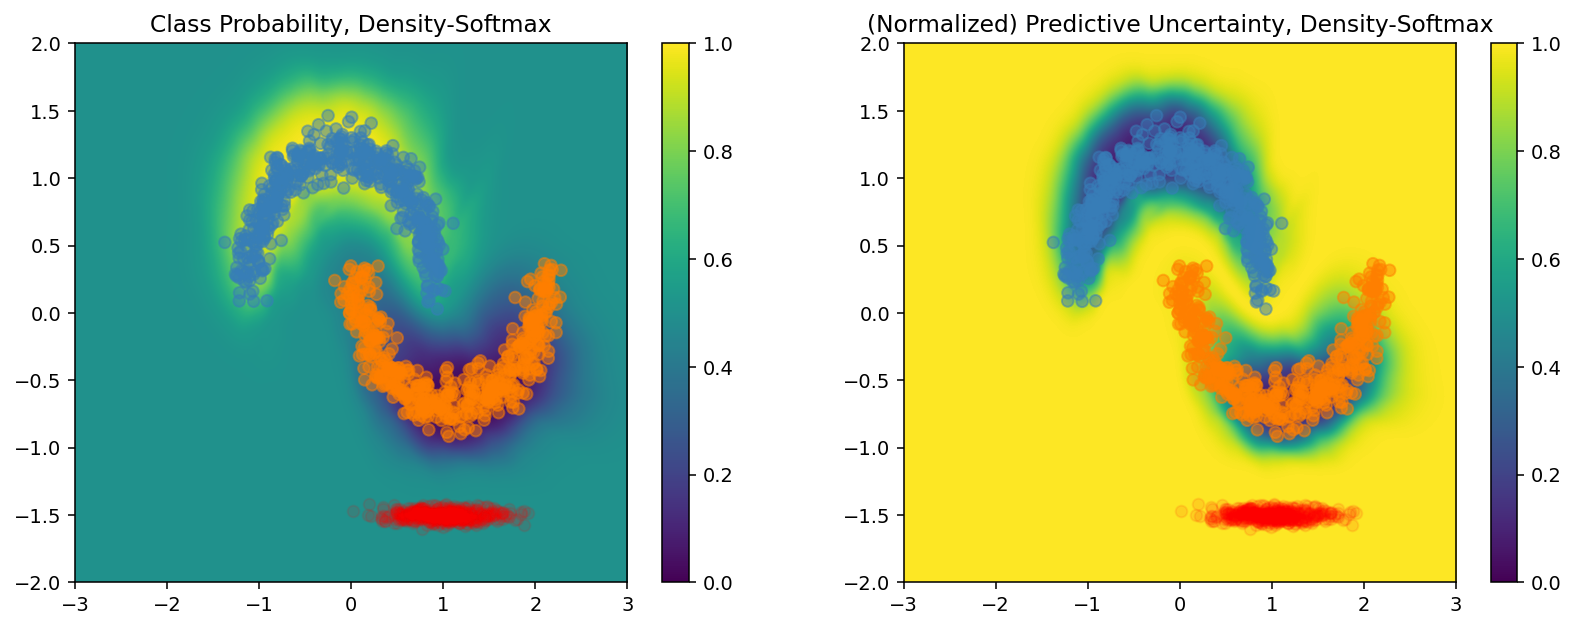

In [15]:
start_time = time.time()
test_latents = resnet_model.encode(test_examples)
resnet_logits = resnet_model.classifier(test_latents)
test_likelihood = tf.exp(flow_model.score_samples(test_latents))
test_likelihood = tf.expand_dims(test_likelihood, 1)

test_likelihood = (test_likelihood)/(train_likelihood_max)
dst_probs = tf.nn.softmax(resnet_logits * tf.cast(test_likelihood, dtype=tf.float32), axis=-1)[:, 0]
density_softmax_infer_time = (time.time() - start_time) * 1e6
plot_predictions(dst_probs, model_name="Density-Softmax")

## Computational comparision at test time

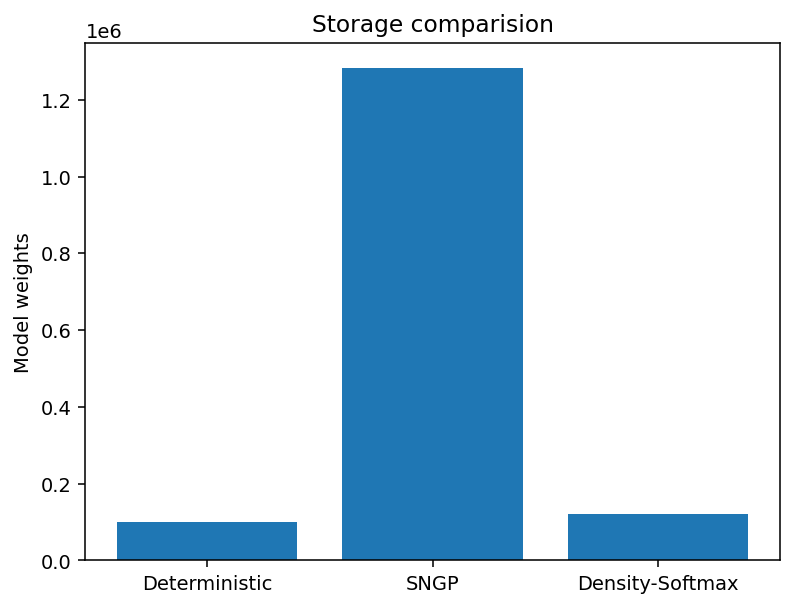

In [16]:
from tensorflow.python.keras.utils import layer_utils

plt.bar([0, 1, 2], [layer_utils.count_params(resnet_model.weights), layer_utils.count_params(sngp_model.weights),
                    layer_utils.count_params(resnet_model.weights) + layer_utils.count_params(flow_model.weights)], align='center')
plt.xticks([0, 1, 2], ('Deterministic', 'SNGP', 'Density-Softmax'))
plt.ylabel('Model weights')
plt.title('Storage comparision')

plt.show()

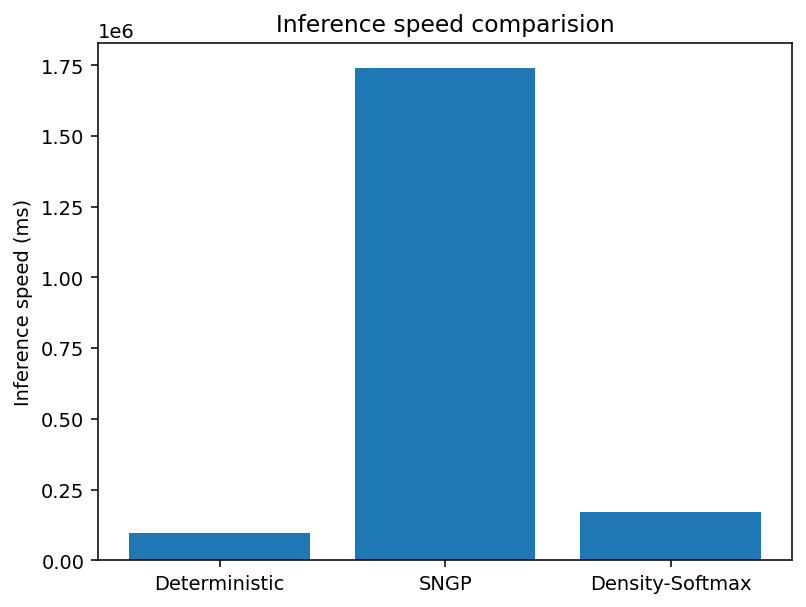

In [17]:
plt.bar([0, 1, 2], [erm_infer_time, sngp_infer_time, density_softmax_infer_time], align='center')
plt.xticks([0, 1, 2], ('Deterministic', 'SNGP', 'Density-Softmax'))
plt.ylabel('Inference speed (ms)')
plt.title('Inference speed comparision')

plt.show()